In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

2022-10-18 15:12:38.749577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 15:12:38.897589: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 15:12:39.470128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-18 15:12:39.470210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
model = tf.keras.models.load_model("models/model40_3l_3c")

2022-10-18 15:12:43.707438: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-10-18 15:12:43.707472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ancoramsi1
2022-10-18 15:12:43.707479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ancoramsi1
2022-10-18 15:12:43.707609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-10-18 15:12:43.707630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-18 15:12:43.707636: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 510.85.2 -- cannot find working devices in this configuration
2022-10-18 15:12:43.707856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

In [3]:
N = 1000
size = 64
imgs = np.zeros((size, size, N))
heatmaps = np.zeros_like(imgs)

for i in range(N):
    imgs[:,:,i] = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    heatmaps[:,:,i] = GradCam(imgs[:,:,i], model, last_conv_layer_idx=-6, pred_index=0)
    

In [5]:
threshold = 0.5

thresholded_heatmaps = np.copy(heatmaps) / 255

thresholded_heatmaps[thresholded_heatmaps > threshold] = 1
thresholded_heatmaps[thresholded_heatmaps <= threshold] = 0


In [6]:
from sklearn.metrics import jaccard_score


jaccard_scores = np.zeros(N)
bbox_range = 22
for i in range(N):
    #find centre of thresholded heatmap
    th_labels = measure.label(np.copy(thresholded_heatmaps[:,:,i]))
    th_centroid = pd.DataFrame(measure.regionprops_table(th_labels, properties=['centroid'])).to_numpy()
    centroid_y = int(th_centroid[0][0])
    centroid_x = int(th_centroid[0][1])

    bbox = np.zeros_like(imgs[:,:,0])
    #create image with bounding box
    y_lower = np.max([0, centroid_y - bbox_range])
    y_upper = np.min([size-1, centroid_y + bbox_range])
    x_lower = np.max([0, centroid_x - bbox_range])
    x_upper = np.min([size-1, centroid_x + bbox_range])
    bbox[y_lower:y_upper, x_lower:x_upper] = 1

    #occlude image according to bounding box
    occluded_img = np.copy(imgs[:,:,i])
    occluded_img[bbox == 0] = 0

    #extract the blobs from the occluded image and get their major axis lengths
    labeled_image = measure.label(occluded_img)
    props = pd.DataFrame(measure.regionprops_table(labeled_image, properties=['area']))

    #find ellipse index
    ellipse_idx = props.idxmax()[0] + 1

    #convert labeled image to binary, setting everything except ellipse to 0
    labeled_image[labeled_image != ellipse_idx] = 0
    labeled_image[labeled_image == ellipse_idx] = 1

    #compute jaccard score and add to array
    jaccard_scores[i] = jaccard_score(labeled_image.astype(int), thresholded_heatmaps[:,:,i].astype(int), average='micro')

array([  0,   3,   6,   8,  16,  41,  45,  50,  52,  54,  55,  57,  67,
        68,  69,  76,  80,  81,  86,  88, 100, 109, 113, 128, 132, 147,
       149, 152, 153, 154, 155, 161, 164, 167, 173, 175, 179, 183, 186,
       199, 202, 210, 218, 220, 223, 224, 227, 237, 243, 244, 250, 252,
       260, 261, 263, 265, 276, 285, 297, 304, 307, 313, 325, 328, 329,
       332, 333, 340, 353, 355, 362, 366, 373, 374, 376, 382, 385, 387,
       391, 403, 404, 406, 408, 410, 423, 425, 427, 432, 439, 447, 456,
       462, 466, 472, 477, 483, 487, 506, 508, 516, 518, 520, 527, 531,
       540, 545, 554, 557, 578, 585, 592, 595, 608, 622, 628, 629, 636,
       644, 647, 648, 649, 670, 675, 677, 680, 683, 684, 691, 694, 696,
       698, 700, 704, 710, 711, 723, 726, 733, 737, 747, 751, 755, 766,
       768, 770, 774, 783, 789, 792, 798, 805, 811, 814, 818, 820, 841,
       859, 862, 867, 870, 873, 876, 878, 895, 901, 903, 909, 922, 924,
       926, 927, 929, 930, 933, 935, 938, 939, 942, 944, 960, 96

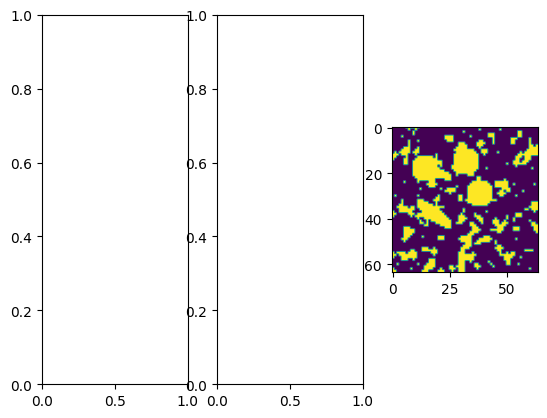

In [24]:
fig, ax = plt.subplots(1,3)


plt.imshow(imgs[:,:,np.where(jaccard_scores == 0)[0][0]])

np.where(jaccard_scores == 0)[0]

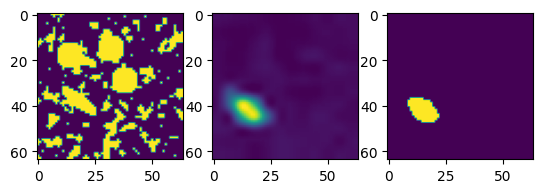

In [50]:
fig, ax = plt.subplots(1,3)
idx = 0
ax[0].imshow(imgs[:,:,idx])
ax[1].imshow(heatmaps[:,:,idx])
ax[2].imshow(thresholded_heatmaps[:,:,idx])

In [51]:
th_labels = measure.label(np.copy(thresholded_heatmaps[:,:,idx]))
th_centroid = pd.DataFrame(measure.regionprops_table(th_labels, properties=['centroid'])).to_numpy()
centroid_y = int(th_centroid[0][0])
centroid_x = int(th_centroid[0][1])


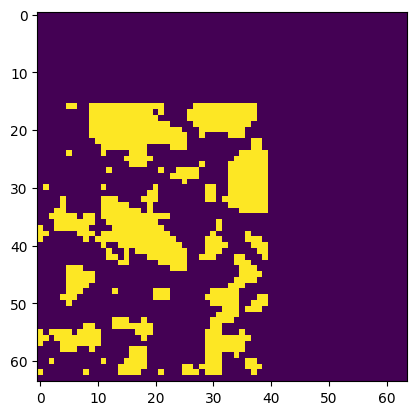

In [52]:
bbox = np.zeros_like(imgs[:,:,0])
range = 25
y_lower = np.max([0, centroid_y - range])
y_upper = np.min([size-1, centroid_y + range])
x_lower = np.max([0, centroid_x - range])
x_upper = np.min([size-1, centroid_x + range])
bbox[y_lower:y_upper, x_lower:x_upper] = 1

x = np.copy(imgs[:,:,idx])
x[bbox == 0] = 0
plt.imshow(x)

In [53]:
labels = measure.label(x)
props = pd.DataFrame(measure.regionprops_table(labels, properties=['area']))

In [54]:
ellipse_idx = props.idxmax()[0] + 1
ellipse_idx

11

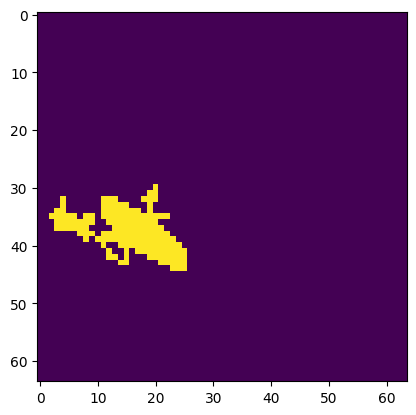

In [55]:
labels[labels != ellipse_idx] = 0
labels[labels == ellipse_idx] = 1
plt.imshow(labels)

0.2037037037037037

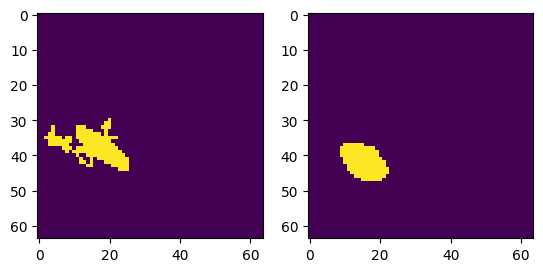

In [23]:
from sklearn.metrics import jaccard_score
fig,ax = plt.subplots(1,2)
ax[0].imshow(labels)
ax[1].imshow(thresholded_heatmaps[:,:,idx])
jaccard_score(labels.astype(int), thresholded_heatmaps[:,:,idx].astype(int), average='micro')